In [45]:
from data.dataset import ICDR2015Dataset
import matplotlib.pyplot as plt
import albumentations as A
import cv2 as cv
import numpy as np
import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dset = ICDR2015Dataset('data/icdr2015')

In [31]:
from PIL import Image

In [39]:
transform = A.Compose([
    A.Resize(640, 640)
])

In [53]:
for i in range(1000):
    img1 = Image.open(f'data/raw/icdr2015/train_images/img_{i + 1}.jpg')
    transform(image=np.array(img1))

In [64]:
img2 = cv.imread(f'data/raw/icdr2015/train_images/img_{1}.jpg')
np.prod(transform(image=img2)['image'].shape)

1228800

In [70]:
# r = np.array([1, 2, 1, 2])
r = np.empty(4)
r[::2] = 1
r[1::2] = 2
print(r)
a = np.array([[1, 2, 3, 4], [5, 6, 7, 8]])

a * r, r.shape, a.shape

[1. 2. 1. 2.]


(array([[ 1.,  4.,  3.,  8.],
        [ 5., 12.,  7., 16.]]),
 (4,),
 (2, 4))

In [65]:
np.prod(img2.shape)

2764800

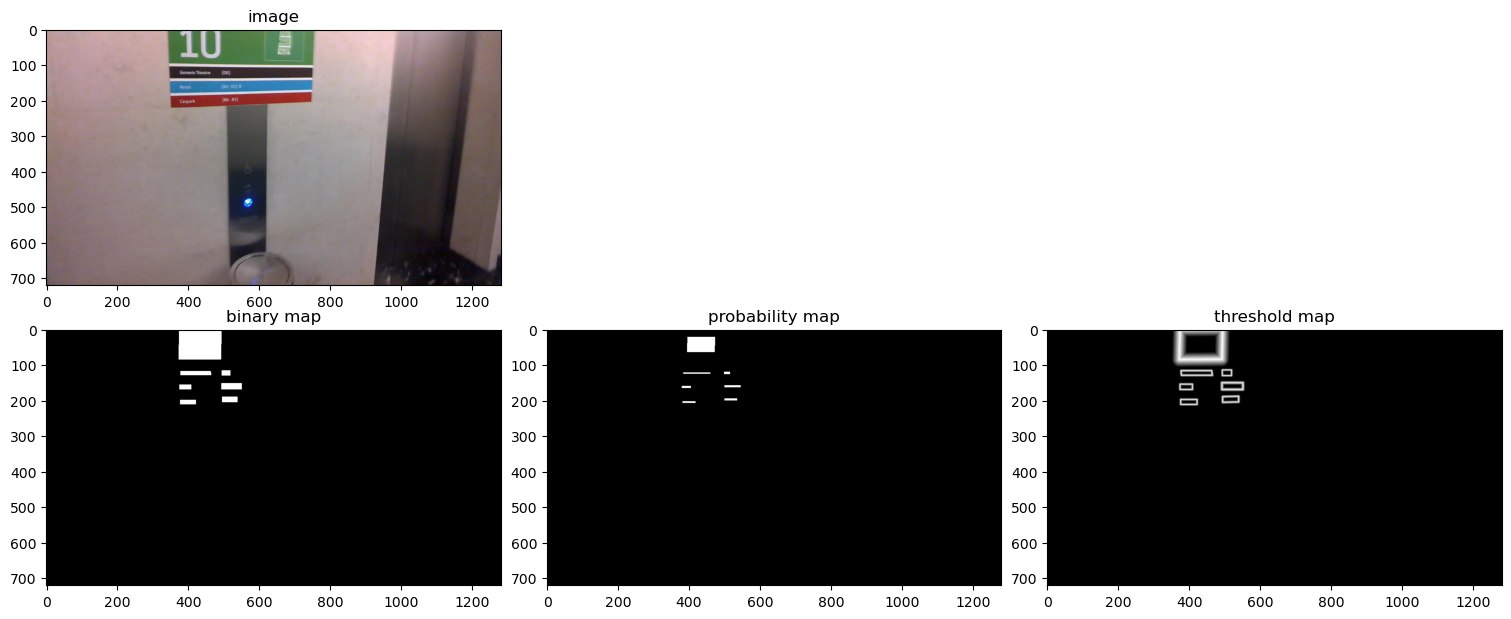

In [7]:
img, (bin_map, prob_map, thresh_map) = dset[0]

fig = plt.figure(layout="constrained", figsize=(15, 6))
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("image")
ax1.imshow(img)

ax3 = fig.add_subplot(gs[1, 0])
ax3.set_title("binary map")
ax3.imshow(bin_map.T, cmap="gray")

ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title("probability map")
ax4.imshow(prob_map.T, cmap="gray")

ax5 = fig.add_subplot(gs[1, 2])
ax5.set_title("threshold map")
ax5.imshow(thresh_map.T, cmap="gray")
ax5.set_xlim(0, prob_map.shape[0])
ax5.set_ylim(prob_map.shape[1], 0)

plt.show()